In [1]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing

In [ ]:
training_set_1 = ['ins2', 'ins5', 'ins6', 'ins7', 'n11', 'n2']
training_set_2 = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15']
training_set_3 = ['plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6']
training_set_4 = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testing_set_1 = ['ins8', 'ins9', 'n5'] 
testing_set_2 = ['nfle16', 'nfle17', 'nfle18', 'nfle19'] 
testing_set_3 = ['plm7', 'plm8', 'plm9']
testing_set_4 = ['rbd18', 'rbd19', 'rbd20']

# Make sure you have the edf and txt files for each individual along with the GitHub modules.

for i in training_set_2:
    psg_data = PSG(i)

    #EEG Feature Extraction
    reload(eeg)
    EEG_columns = eeg.EEG(psg_data.data)
    EEG_columns.extract_features()
    eeg_data = EEG_columns.eeg_features

    #SAO2 Feature Extraction
    oxyData = psg_data.data[['epoch','SAO2']]
    sao2_data = SAO2(oxyData).get_SAO2_metrics()

    #EOG Feature Extraction
    eog_data = EOG(psg_data.data).get_EOG_metrics()

    #EMG Feature Extraction
    sxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "SX1-SX2"]]
    sx = EMG(sxDfInput, signalType = "SX1-SX2")
    sx_data = sx.getMetrics()

    dxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "DX1-DX2"]]
    dx = EMG(dxDfInput, signalType = "DX1-DX2")
    dx_data = dx.getMetrics()

    emgDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "EMG1-EMG2"]]
    emg_columns = EMG(emgDfInput)
    emg_data = emg_columns.getMetrics()

    #ECG Feature Extraction
    ecgDfInput = psg_data.data.loc[:, ["epoch", "ECG1-ECG2"]]
    ecg_columns = ECG(ecgDfInput)
    ecg_data = ecg_columns.getMetrics()

    plethDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "PLETH"]]
    pleth = ECG(plethDfInput, signalType = 'PLETH')
    pleth_data = pleth.getMetrics()

    #Combine and Export Data
    stage_1 = pd.merge(psg_data.txtData, eeg_data, how = 'left', on='epoch')
    stage_2 = pd.merge(stage_1, sao2_data, how = 'left', on='epoch')
    stage_3 = pd.merge(stage_2, eog_data, how = 'left', on='epoch')
    stage_4 = pd.merge(stage_3, sx_data, how = 'left', on='epoch')
    stage_5 = pd.merge(stage_4, dx_data, how = 'left', on='epoch')
    stage_6 = pd.merge(stage_5, emg_data, how = 'left', on='epoch')
    stage_7 = pd.merge(stage_6, ecg_data, how = 'left', on='epoch')
    final = pd.merge(stage_7, pleth_data, how = 'left', on='epoch')

    final.to_csv(i+'.csv')
    print(i+" successfully exported!")


In [37]:
# Create Combined Dataset with unique patient identifier column:
files = ['plm1', 'plm2']

data = pd.read_csv(files[0] + '.csv')
data.insert(1, "Patient", files[0])

for file in files[1:]:
    thisData = pd.read_csv(file + '.csv')  
    thisData.insert(1, "Patient", file)
    pd.concat([data, thisData])

In [38]:
# Fill in missing datapoints (K Nearest Neighbors):

### Option: Truncate based on shortest columns?

firstNumericCol = 7

impute_KNN = data.iloc[:, firstNumericCol:]
imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
data.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)



In [39]:
# Drop current "_norm" cols:
for col in data.columns:
    if "_norm" in col:
        data.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in data["Patient"].unique():
    thisPatientMeans = data[data["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    data[data["Patient"] == patient].iloc[:, firstNumericCol:] /= thisPatientMeans

# Center:
data.iloc[:, firstNumericCol:] -= data.iloc[:, firstNumericCol:].mean(axis = 0)

# Scale:
data.iloc[:, firstNumericCol:] /= data.iloc[:, firstNumericCol:].std(axis = 0)

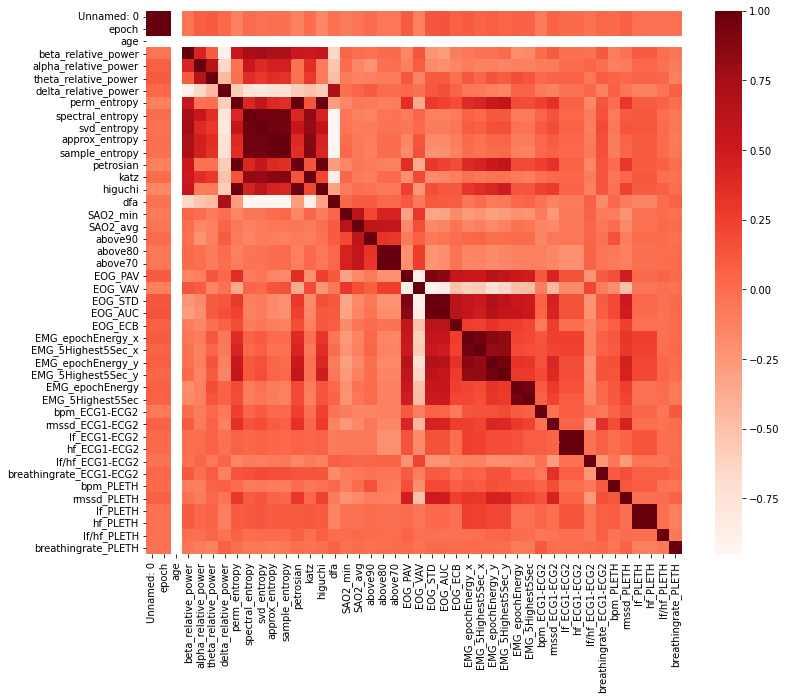

In [43]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [40]:
# Data Transformation - Box Cox followed by Min-Max Scaling
final = pd.read_csv(i+'.csv')

final.dropna(subset = ['hf_PLETH'], inplace=True)

for column in final.columns[firstNumericCol:]:
    final[column] = final[column].abs()
        
    try:
        box_cox_trans = stats.boxcox(final[column])[0]
        normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
        final[column] = (normalized-normalized.min())/(normalized.max()-normalized.min())
        
    except:
        normalized = (final[column]-final[column].mean()) / final[column].std()
        final[column] = (normalized-normalized.min())/(normalized.max()-normalized.min())
        

NameError: name 'i' is not defined

In [ ]:
### Remove Outliers ###

In [ ]:
# Dummy Encoding of Gender/Condition and Ordinal Encoding of Sleep Stage
# Drop 1st column (previous index from processing)
final.drop("Unnamed: 0", axis=1, inplace=True)

# Add columnS for sleep stage
final.insert(2, "sleep_stage", np.zeros(len(final)))

# Replace sleep stage string with numerical value
for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

# Drop original sleep stage column
final.drop("Sleep Stage", axis=1, inplace=True)

# Replace sleep stage string with numerical value
for condition in constants.CONDITION_TO_BINARY:
    # Only check 1st row to confirm condition
    if condition == final.at[0, "condition"]:
        binary = constants.CONDITION_TO_BINARY.get(condition)

        # 1st Binary digit
        if binary[0] == 0:
            final.insert(3, "condition_0", np.zeros(len(final)))
        else:
            final.insert(3, "condition_0", np.ones(len(final)))

        # 2nd Binary digit
        if binary[1] == 0:
            final.insert(4, "condition_1", np.zeros(len(final)))
        else:
            final.insert(4, "condition_1", np.ones(len(final)))

        # 3rd Binary digit
        if binary[2] == 0:
            final.insert(5, "condition_2", np.zeros(len(final)))
        else:
            final.insert(5, "condition_2", np.ones(len(final)))
            

# Drop original sleep stage column
final.drop("condition", axis=1, inplace=True)

In [29]:
allData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']
firstNumericCol = 6 # Includes age

final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(dataset+'.csv')
    column_names = thisData.columns[firstNumericCol - 1:]
    # final.dropna(subset = ['hf_PLETH'], inplace=True)
        # Commented this out because added data imputing

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] /= thisPatientMeans

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling done for " + dataset)

#Box-Cox and Min-Max
for column in final.columns[firstNumericCol:]:
    final[column] = final[column].abs()
    
    try:
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
        #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
        #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
    except:
        #normalized = (final[column]-final[column].mean()) / final[column].std()
        final[column] = box_cox_trans
        #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
print("Box-Cox and Min-Max done for " + dataset)     

#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2"]]])
final.insert(5, "condition_0", conditionColumns["condition_0"])
final.insert(6, "condition_1", conditionColumns["condition_1"])
final.insert(7, "condition_2", conditionColumns["condition_2"])

final.drop("condition", axis=1, inplace=True)
print('Encoding done for ' + dataset)


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.to_csv('final.csv')
print(dataset+" successfully exported!")

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


Robust Scaling done for rbd17
Box-Cox and Min-Max done for rbd17
Encoding done for rbd17
rbd17 successfully exported!


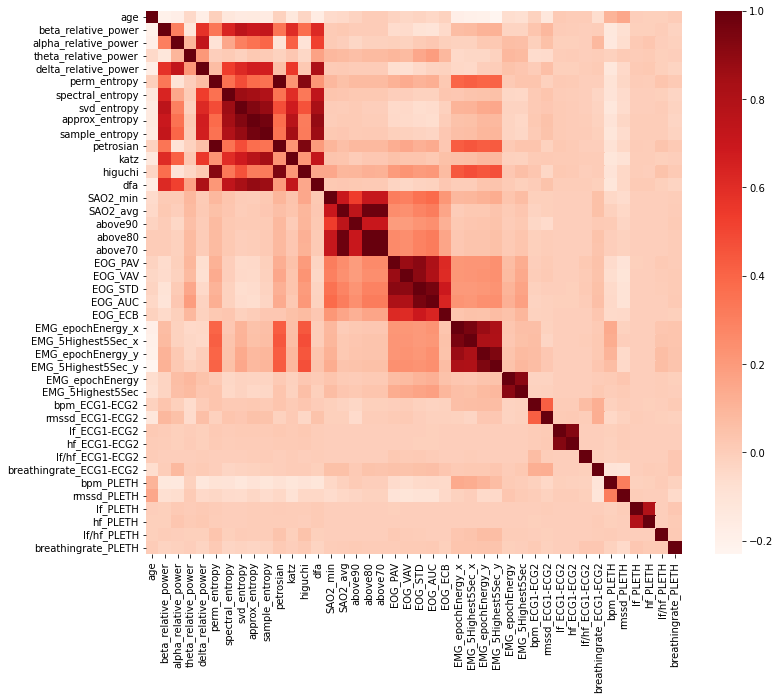

              Feature A             Feature B      Corr
170             above70               above80  0.999645
50            petrosian          perm_entropy  0.997101
168             above70              SAO2_avg  0.980798
151             above80              SAO2_avg  0.980783
44       sample_entropy        approx_entropy  0.969039
252             EOG_AUC               EOG_STD  0.961299
324  EMG_5Highest5Sec_x     EMG_epochEnergy_x  0.953147
377  EMG_5Highest5Sec_y     EMG_epochEnergy_y  0.940585
76              higuchi             petrosian  0.938745
35       approx_entropy           svd_entropy  0.930169
560        hf_ECG1-ECG2          lf_ECG1-ECG2  0.925917
71              higuchi          perm_entropy  0.918460
434    EMG_5Highest5Sec       EMG_epochEnergy  0.911714
229             EOG_STD               EOG_PAV  0.911306
230             EOG_STD               EOG_VAV  0.907641
86                  dfa        approx_entropy  0.886800
43       sample_entropy           svd_entropy  0

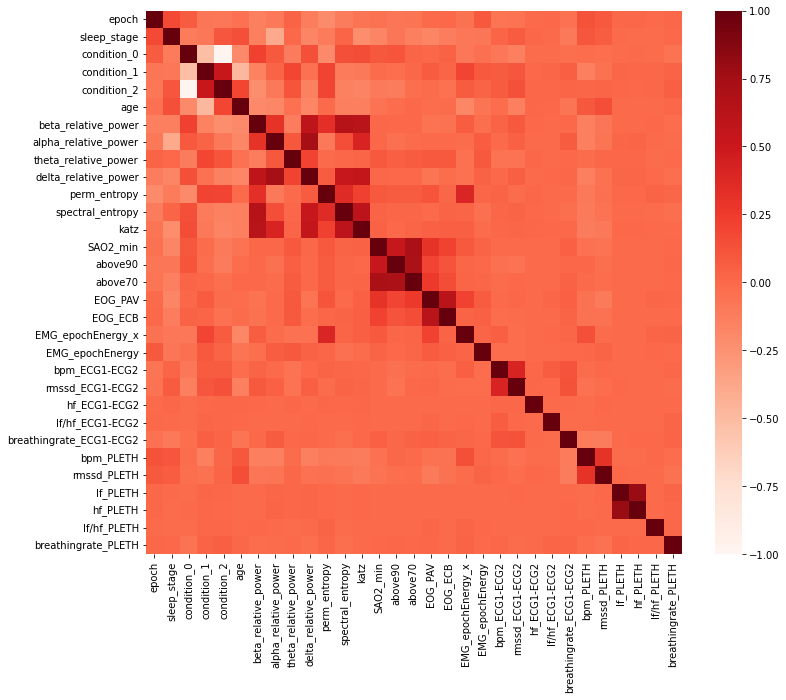

In [62]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['epoch', 'sleep_stage', 'condition_0', 'condition_1', 'condition_2'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))

# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()
    

In [54]:
print(averageCorr)
print(averageCorr.loc["above70", "avgCorr"])

                          avgCorr
age                      0.101672
beta_relative_power      0.202810
alpha_relative_power     0.131422
theta_relative_power     0.077565
delta_relative_power     0.177953
perm_entropy             0.197154
spectral_entropy         0.192442
svd_entropy              0.227382
approx_entropy           0.219567
sample_entropy           0.218926
petrosian                0.201889
katz                     0.189845
higuchi                  0.212499
dfa                      0.202465
SAO2_min                 0.156991
SAO2_avg                 0.153866
above90                  0.130242
above80                  0.153758
above70                  0.153574
EOG_PAV                  0.184495
EOG_VAV                  0.185601
EOG_STD                  0.196871
EOG_AUC                  0.198335
EOG_ECB                  0.127243
EMG_epochEnergy_x        0.167631
EMG_5Highest5Sec_x       0.170841
EMG_epochEnergy_y        0.177720
EMG_5Highest5Sec_y       0.181317
EMG_epochEnerg